# Analysis

In [14]:
import polars as pl
import matplotlib.pyplot as plt
import glob
import os
import shutil
import matplotlib.pyplot as plt
from datetime import datetime


## Minimum/ Maximum energy consumed in 15 mins per season


In [15]:
pattern = f"{'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_raw'}/*CH*.csv"

files = glob.glob(pattern)

print(f"Number of found files: {len(files)}")

result_list = []



for file in files:
    df = pl.read_csv(file)
    durchschnitt = df["bruttolastgang_kwh"].mean()
    file_id = os.path.basename(file).split("__")[1].split("_")[0]
    # Hier neuen DataFrame mit den Werten erzeugen
    min_value = df["bruttolastgang_kwh"].min()
    max_value = df["bruttolastgang_kwh"].max()
    total = df["bruttolastgang_kwh"].sum()
    mean_row = pl.DataFrame({
        "file_id": [file_id],
        "bruttolastgang_kwh_mean": [durchschnitt],
        "bruttolastgang_kwh_min": [min_value],
        "bruttolastgang_kwh_max": [max_value],
        "bruttolastgang_kwh_sum": [total]
        })
    result_list.append(mean_row)

means_all = pl.concat(result_list)
#means_all.write_csv("alle_mittelwerte.csv")



Number of found files: 1481


In [16]:
# Average daily consumption calculation

result_list_daily_avg = []

for file in files:
    df = pl.read_csv(file)
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.date().alias("date")
    )
    daily_sum = df.group_by("date").agg(
        pl.col("bruttolastgang_kwh").sum().alias("daily_total_kwh")
    )
    avg_daily_cons = daily_sum["daily_total_kwh"].mean()
    file_id = os.path.basename(file).split("__")[1].split("_")[0]
    avg_row = pl.DataFrame({
        "file_id": [file_id],
        "average_daily_consumption": [avg_daily_cons]
    })
    result_list_daily_avg.append(avg_row)

daily_avg_df = pl.concat(result_list_daily_avg)

# Join the two DataFrames on file_id
final_df_1 = means_all.join(daily_avg_df, on="file_id", how="left")



In [17]:
# average hourly consumption calculation


result_list_avg = []
for file in files:
    df = pl.read_csv(file)
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
        # Extract year-month-day-hour for grouping (truncate minutes, seconds)
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.truncate("1h").alias("hour")
    )
    
    # Sum 4 measurements per hour to get total hourly consumption
    hourly_sum = df.group_by("hour").agg(
        pl.col("bruttolastgang_kwh").sum().alias("hourly_kwh_sum")
    )
    
    # Calculate average hourly consumption over all hours
    avg_hourly_consumption = hourly_sum["hourly_kwh_sum"].mean()

    file_id = os.path.basename(file).split("__")[1].split("_")[0]
    avg_row = pl.DataFrame({
        "file_id": [file_id],
        "average_hourly_consumption": [avg_hourly_consumption]
    })
    result_list_avg.append(avg_row)

hourly_avg_df = pl.concat(result_list_avg)

# Join the two DataFrames on file_id
final_df_2 = final_df_1.join(hourly_avg_df, on="file_id", how="left")



In [18]:
# average weekend consumption calculation

result_list_weekend = []

for file in files:
    df = pl.read_csv(file)
    
    # Parse timestamp
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    
    # Extract date and weekday
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.date().alias("date"),
        pl.col("zeitpunkt_dt").dt.weekday().alias("weekday")  # Monday=0, Sunday=6
    )
    
    # Filter weekends (Saturday=5, Sunday=6)
    weekend_df = df.filter(pl.col("weekday").is_in([6, 7]))
    
    # Sum consumption per weekend day
    weekend_daily_sum = weekend_df.group_by("date").agg(
        pl.col("bruttolastgang_kwh").sum().alias("daily_kwh_sum")
    )
    
    # Average daily consumption over weekend days
    avg_weekend_consumption = weekend_daily_sum["daily_kwh_sum"].mean()
    
    file_id = os.path.basename(file).split("__")[1].split("_")[0]
    weekend_avg_row = pl.DataFrame({
        "file_id": [file_id],
        "average_weekend_daily_consumption": [avg_weekend_consumption]
    })
    result_list_weekend.append(weekend_avg_row)

weekend_avg_df = pl.concat(result_list_weekend)

# Join the two DataFrames on file_id
final_df_3 = final_df_2.join(weekend_avg_df, on="file_id", how="left")

In [19]:
# average weekday consumption calculation

result_list_weekday = []

for file in files:
    df = pl.read_csv(file)
    
    # Parse timestamp
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    
    # Extract date and weekday
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.date().alias("date"),
        pl.col("zeitpunkt_dt").dt.weekday().alias("weekday")  # Monday=0, Sunday=6
    )
    
    # Filter weekday (Monday=1 to Friday=5)
    weekday_df = df.filter(pl.col("weekday").is_in([1,2,3,4,5]))
    
    # Sum consumption per weekday day
    weekday_daily_sum = weekday_df.group_by("date").agg(
        pl.col("bruttolastgang_kwh").sum().alias("daily_kwh_sum")
    )
    
    # Average daily consumption over weekday days
    avg_weekday_consumption = weekday_daily_sum["daily_kwh_sum"].mean()
    
    file_id = os.path.basename(file).split("__")[1].split("_")[0]
    weekday_avg_row = pl.DataFrame({
        "file_id": [file_id],
        "average_weekday_daily_consumption": [avg_weekday_consumption]
    })
    result_list_weekday.append(weekday_avg_row)

weekday_avg_df = pl.concat(result_list_weekday)

# Join the two DataFrames on file_id
final_df = final_df_3.join(weekday_avg_df, on="file_id", how="left")



In [20]:
def day_avg_preprocess_season(df, season):
    # Define timestamp ranges per season
    if season == "spring":
        timestamp_range = pl.datetime_range(datetime(2024,3,1), datetime(2024,5,31), "1d", eager=True)
    elif season == "summer":
        timestamp_range = pl.datetime_range(datetime(2024,6,1), datetime(2024,8,31), "1d", eager=True)
    elif season == "autumn":
        timestamp_range = pl.datetime_range(datetime(2024,9,1), datetime(2024,11,30), "1d", eager=True)
    else:  # winter
        timestamp_range = pl.concat([
            pl.datetime_range(datetime(2024,1,1), datetime(2024,2,28), "1d", eager=True),
            pl.datetime_range(datetime(2024,12,1), datetime(2024,12,31), "1d", eager=True)
        ])

    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.date().alias("date_only")
    )

    timestamp_range = timestamp_range.cast(pl.Date)

    df_season = df.filter(
        pl.col("date_only").is_in(timestamp_range.implode())
    )

    # Sum per day in season
    daily_sum = df_season.group_by("date_only").agg(
        pl.col("bruttolastgang_kwh").sum().alias("daily_kwh_sum")
    )

    avg_season_consumption = daily_sum["daily_kwh_sum"].mean()

    return avg_season_consumption


result_list_seasons = []

season_dfs = {}

for season in ["spring", "summer", "autumn", "winter"]:
    season_results = []
    for file in files:
        df = pl.read_csv(file)
        avg_season_consumption = day_avg_preprocess_season(df, season)
        file_id = os.path.basename(file).split("__")[1].split("_")[0]
        season_results.append(
            pl.DataFrame({
                "file_id": [file_id],
                f"avg_daily_{season}": [avg_season_consumption]
            })
        )
    # Concatenate rows (same columns)
    season_dfs[season] = pl.concat(season_results)

# Now join all season DataFrames on 'file_id'
final_season_df = season_dfs["spring"]

for season in ["summer", "autumn", "winter"]:
    right_df = season_dfs[season]
    
    final_season_df = final_season_df.join(
        right_df,
        on="file_id",
        how="left"
    )

# Join with your existing final_df
final_df = final_df.join(final_season_df, on="file_id", how="left")



In [21]:
def day_avg_preprocess_day(df, day):
    # Define timestamp ranges per season
    
    # Parse timestamp
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    
    # Extract date and weekday
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.date().alias("date"),
        pl.col("zeitpunkt_dt").dt.weekday().alias("weekday")  # Monday=0, Sunday=6
    )
    
    # Filter weekday (Monday=1 to Friday=5)
    day_df = df.filter(pl.col("weekday").is_in([day]))
    
    # Sum consumption per weekday day
    day_daily_sum = day_df.group_by("date").agg(
        pl.col("bruttolastgang_kwh").sum().alias("daily_kwh_sum")
    )
    
    # Average daily consumption over weekday days
    avg_day_consumption = day_daily_sum["daily_kwh_sum"].mean()

    return avg_day_consumption


result_list_day = []

day_dfs = {}

for day in [1,2,3,4,5,6,7]:
    day_results = []
    for file in files:
        df = pl.read_csv(file)
        avg_day_consumption = day_avg_preprocess_day(df, day)
        file_id = os.path.basename(file).split("__")[1].split("_")[0]
        day_results.append(
            pl.DataFrame({
                "file_id": [file_id],
                f"avg_day_{day}": [avg_day_consumption]
            })
        )
    # Concatenate rows (same columns)
    day_dfs[day] = pl.concat(day_results)

# Now join all season DataFrames on 'file_id'
final_day_df = day_dfs[1]

for day in [2,3,4,5,6,7]:
    right_df = day_dfs[day]
    
    final_day_df = final_day_df.join(
        right_df,
        on="file_id",
        how="left"
    )

# Join with your existing final_df
final_df = final_df.join(final_day_df, on="file_id", how="left")

In [22]:
# Alle Mittelwerte zu einer Übersicht zusammenfassen
print(final_df.columns)

final_df.write_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")

['file_id', 'bruttolastgang_kwh_mean', 'bruttolastgang_kwh_min', 'bruttolastgang_kwh_max', 'bruttolastgang_kwh_sum', 'average_daily_consumption', 'average_hourly_consumption', 'average_weekend_daily_consumption', 'average_weekday_daily_consumption', 'avg_daily_spring', 'avg_daily_summer', 'avg_daily_autumn', 'avg_daily_winter', 'avg_day_1', 'avg_day_2', 'avg_day_3', 'avg_day_4', 'avg_day_5', 'avg_day_6', 'avg_day_7']


## Outlier

create a min_max_full.csv file containing the peak and total yearly consumption of the household using the previous code.

In [26]:
min_max_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")

# Define outlier condition
outlier_condition = (
    (min_max_df["bruttolastgang_kwh_max"] == 0)
)

#outlier_condition = (
#    (min_max_df["bruttolastgang_kwh_max"] == 0) |
#    (min_max_df["bruttolastgang_kwh_max"] > 10) |
#    (min_max_df["bruttolastgang_kwh_sum"] > 25000)
#)

# Filter the DataFrame to get only outliers
outliers_df = min_max_df.filter(outlier_condition)

# Save outliers to CSV
outliers_df.write_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/outliers.csv")

# Remove outliers by filtering rows that do NOT fulfill the outlier condition
cleaned_df = min_max_df.filter(~outlier_condition)

# Save cleaned data to a new CSV file (or overwrite original if desired)
cleaned_df.write_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")

In [27]:
source_folder = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_raw"
target_folder = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned"
os.makedirs(target_folder, exist_ok=True)

# 1. Load outliers file IDs (assumed stored in column "file_id")
outliers_df = pl.read_csv(os.path.join("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA", "outliers.csv"))
outlier_ids = set(outliers_df["file_id"].to_list())

# 2. List all *CH*.csv files in source folder (non-recursive)
files = glob.glob(os.path.join(source_folder, "*CH*.csv"))

for file_path in files:
    file_name = os.path.basename(file_path)
    # 3. Extract CH-part from filename (adapt extraction logic as before)
    try:
        file_id = file_name.split("__")[1].split("_")[0]
    except IndexError:
        # Skip or copy if filename pattern doesn't fit expected pattern
        file_id = None
    
    # 4. Copy only if file_id not in outliers
    if file_id not in outlier_ids:
        shutil.copy2(file_path, os.path.join(target_folder, file_name))

## Peak vs Total Yearly Consumption plot

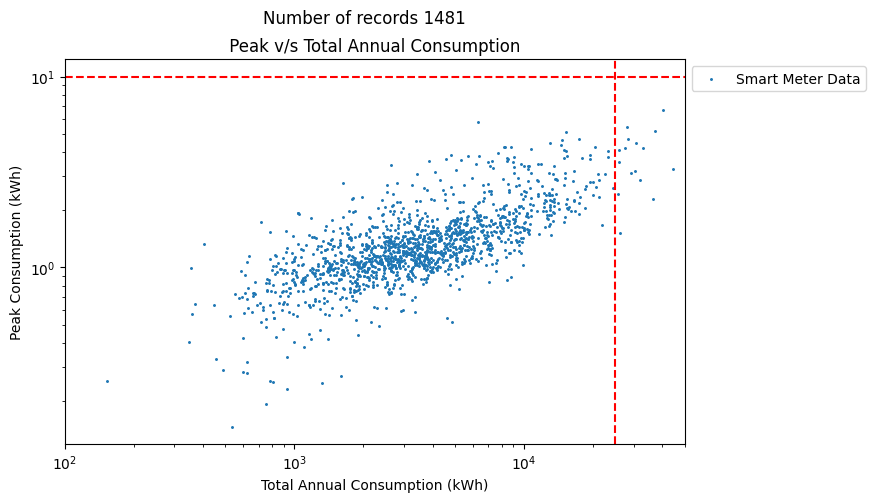

In [28]:
min_max_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")

plt.figure(figsize=[8,5])
plt.scatter(min_max_df['bruttolastgang_kwh_sum'], min_max_df['bruttolastgang_kwh_max'], marker=".", s=5, label='Smart Meter Data')
plt.title(" Peak v/s Total Annual Consumption ")
plt.suptitle(f"Number of records {len(min_max_df)}")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Total Annual Consumption (kWh)")
plt.ylabel("Peak Consumption (kWh)")
plt.xlim(100, 50000)

# Add lines
plt.axhline(y=10, color='red', linestyle='--')
plt.axvline(x=25000, color='red', linestyle='--')

# Shade regions outside the lines
#plt.axhspan(plt.ylim()[1], 10, color='lightgrey', alpha=0.5)
#plt.axvspan(plt.xlim()[1], 25000, color='lightgrey', alpha=0.5)

plt.show()